In [1]:
import numpy as np
import math
from deap import base, creator, tools
import random
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
import json
import pandas as pd


## Visualização de escoamento


### Mapa de calor
0 - azul

1 - vermelho

eixo x,y e z (plano)

### Mapa de resultados numeros com vetores de mesmo tamanho


### Resultados numeros com linhas de corrente
- linhas de corrente: linhas tangentes a velocidade (somatorio). linha de tangete a linha do vetor velocidade (trajetoria da particula do vetor da velocidade)

[ ] Implementação do programa e simulaçoes

[ ] Coleta e analise de dados

- Ajustar os aleatórios do RCE.
- Utilizar estruturas do DEAP (individual) para as variáveis de decisão (verificar).
- Fazer backup da nova versão no drive

11ª Reunião (Remota)
- Verificar pendências
- Ajustar o RCE, seguindo passo a passo no chat do google.
- Utilizar estruturas do DEAP (individual) para as variáveis de decisão (verificar).
- Fazer backup da nova versão no drive
- Tipo, qtde e limite de variáveis de decisão são dados de entrada e impactam em ajuste da função individual do DEAP (isso será visto depois).
- Verificar se a explicação do resultado e os gráficos estão corretos.

## Classe Setup e DataExploration

In [2]:
class Setup:
    def __init__(self, params):
        self.params = params
        self.CXPB = params["CROSSOVER"]
        self.MUTPB = params["MUTACAO"]
        self.NGEN = params["NUM_GENERATIONS"]
        self.POP_SIZE = params["POP_SIZE"]
        self.IND_SIZE = params["IND_SIZE"]
        self.CROSSOVER, self.MUTACAO, self.NUM_GENERATIONS, self.POPULATION_SIZE = (
            self.CXPB,
            self.MUTPB,
            self.NGEN, 
            self.POP_SIZE,
        )
        self.SIZE_INDIVIDUAL = self.IND_SIZE
        self.evaluations = 0
        self.num_repopulation = int(self.NUM_GENERATIONS * 0.20)
        self.type = params["type"].lower()
        if self.type == "maximize":
            print("Método escolhido: Maximizar")
            creator.create("Fitness", base.Fitness, weights=(1.0,))
        else:
            print("Método escolhido: Minimizar")
            creator.create("Fitness", base.Fitness, weights=(-1.0,))

        # creator.create("Individual", list, fitness=creator.Fitness)

        self.dataset = {}
        self.beta_constants = {}


        #!Criando invidivuo
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create(
            "Individual", list, fitness=creator.FitnessMin, rce=str, index=int
        )
        self.toolbox = base.Toolbox()
        # todo gerando atributos ao ind
        self.toolbox.register(
            "attr_rce", random.uniform, 0.0, 9.9
        )  
        self.toolbox.register("attr_int", random.uniform, 1, 1000)

        self.toolbox.register("attribute", random.uniform, -5.12, 5.12)
        self.toolbox.register(
            "individual",
            tools.initRepeat,
            creator.Individual,
            self.toolbox.attribute,
            n=self.SIZE_INDIVIDUAL,
        )

        #paramentos evolutivos
        self.toolbox.register(
            "population", tools.initRepeat, list, self.toolbox.individual
        )
        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
        self.toolbox.register("select", tools.selTournament, tournsize=3)
        self.toolbox.register("evaluate", self.evaluate_fitness)

    def evaluate_fitness(self, individual):
        if self.type == "minimaze":
            result = minimize(self.rastrigin, x0=np.zeros(self.IND_SIZE), method="BFGS")
            fitness_value = result.fun
        return fitness_value

    def gerarDataset(self, excel):
        df = pd.read_excel(excel)
        print(df.columns)
        self.dataset = {
            "CXPB": self.CROSSOVER,
            "TAXA_MUTACAO": self.MUTACAO,
            "NUM_GEN": self.NUM_GENERATIONS,
            "POP_SIZE": self.POPULATION_SIZE,
            "IND_SIZE": self.SIZE_INDIVIDUAL,
            "evaluations": self.evaluations,
            "NUM_REPOPULATION": self.num_repopulation,
        }

    def rastrigin(self, individual):
        self.evaluations += 1
        rastrigin = 10 * self.SIZE_INDIVIDUAL
        for i in range(self.SIZE_INDIVIDUAL):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

    def rastrigin_decisionVariables(self, individual, decision_variables):
        self.evaluations += 1
        rastrigin = 10 * len(decision_variables)
        for i in range(len(decision_variables)):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

    def rosenbrock(self, x):
        return np.sum(100 * (x[1:] - x[:-1] ** 2) ** 2 + (1 - x[:-1]) ** 2)

    def globalSolutions(self):
        n_dimensions = 2

        try:
            rastrigin_result = minimize(
                self.rastrigin, x0=np.zeros(n_dimensions), method="BFGS"
            )
            rastrigin_minimum = rastrigin_result.fun
            rastrigin_solution = rastrigin_result.x

            rosenbrock_result = minimize(
                self.rosenbrock, x0=np.zeros(n_dimensions), method="BFGS"
            )
            rosenbrock_minimum = rosenbrock_result.fun
            rosenbrock_solution = rosenbrock_result.x

        except Exception as e:
            print("Erro ao tentar encontrar o ótimo global das funções: ", e)

        print("\n\nÓtimo global da função Rastrigin: ", rastrigin_minimum)
        print("Solução: ", rastrigin_solution)
        print()
        print("Ótimo global da função Rosenbrock: ", rosenbrock_minimum)
        print("Solução: ", rosenbrock_solution)


class DataExploration:
    def __init__(self):
        self.fit_array = []

    def default_rastrigin(self,x, y):
        return 20 + x**2 + y**2 - 10 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))


    def generateSimpleDataset(self):
        # Geração dos dados
        data = pd.DataFrame(
            {
                'x': np.linspace(-5, 5, 400),
                'y': np.linspace(-5, 5, 400)
            }

        )

        #display(data)

        # Generate meshgrid data
        x = np.linspace(-5.15, 5.15, 100)
        y = np.linspace(-5.15, 5.15, 100)
        X, Y = np.meshgrid(x, y)

        # Calculate function values
        #print(X.shape,Y.shape)

        return X,Y

    def plot_Rastrigin_2D(self,X, Y, Z_rastrigin,logbook ,best_variables =[] ):
        fig = plt.figure(figsize=(18, 10))
        ax1 = fig.add_subplot(231)
        generation = logbook.select("gen")
        statics = self.calculate_stats(logbook)
        line1 = ax1.plot(generation, statics["min_fitness"], "*b-", label="Minimum Fitness")
        line2 = ax1.plot(generation, statics["avg_fitness"], "+r-", label="Average Fitness")
        line3 = ax1.plot(generation, statics["max_fitness"], "og-", label="Maximum Fitness")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        ax1.set_title("GERAÇÃO X FITNESS")
        lns = line1 + line2 + line3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc="upper right")


        # Rastrigin 2D
        ax2 = fig.add_subplot(232)
        ax2.contourf(X, Y, Z_rastrigin, levels=50, cmap='viridis')
        #ax2.plot(best_variables, color='red',)
        for num in range(len(best_variables)):
            var_x = round(best_variables[num])
            var_y = best_variables[num]
            ax2.scatter(var_x,var_y, color = "pink",    marker="o" , label='best variables')
        ax2.set_title('Rastrigin Function 2D')
        ax2.set_xlabel("X")
        ax2.set_ylabel('Y')


        #Rastrigin 3D
        ax5 = fig.add_subplot(233, projection='3d')
        ax5.plot_surface(X, Y, Z_rastrigin, cmap='viridis', edgecolor='none')
        ax5.set_title('Rastrigin Function 3D')
        ax5.set_xlabel('X')
        ax5.set_ylabel('Y')
        ax5.set_zlabel('Z')

        plt.tight_layout()
        plt.show()


    def show_rastrigin_benchmark(self,logbook,best = []):
        X,Y = self.generateSimpleDataset()

        Z_3D_rastrigin = self.default_rastrigin(X,Y )

        self.plot_Rastrigin_2D(X, Y, Z_3D_rastrigin,logbook,best)    

    def statistics_per_generation_df(self, logbook):
        generations = logbook.select("gen")
        min_fitness = logbook.select("min")
        avg_fitness = logbook.select("avg")
        max_fitness = logbook.select("max")
        std_fitness = logbook.select("std")

        data = {
            "Generation": generations,
            "Min Fitness": min_fitness,
            "Average Fitness": avg_fitness,
            "Max Fitness": max_fitness,
            "Std Fitness": std_fitness,
        }

        df = pd.DataFrame(data)
        display(df)

    def plot_diversidade_genes(self, population):
        print("Plotando diversidade dos genes")
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        x_values = [ind[0] for ind in population]  # Retorna a primeira posição do vetor
        y_values = [ind[1] for ind in population]  # Retorna a segunda posição do vetor

        ax.scatter(x_values, y_values, c="b", label="Population")
        ax.set_title("Diversity of genes")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.legend()
        plt.show()

    def plot_scatter_turbina(self, turbina, best_variables):
        # Plotar o gráfico de dispersão
        plt.figure(figsize=(10, 6))

        plt.scatter(
            turbina["Curva_Teórica(KWh)"],
            turbina["ActivePower(kW)"],
            label="Dados Reais",
            color="blue",
        )
        plt.plot(
            turbina["Curva_Teórica(KWh)"],
            best_variables * turbina["Curva_Teórica(KWh)"],
            label="Melhor Solução",
            color="red",
        )

        plt.xlabel("Potência Teórica (KWh)")
        plt.ylabel("Potência Ativa (kW)")
        plt.title("Comparação entre Potência Teórica e Potência Ativa")
        plt.legend()
        plt.grid(True)
        plt.show()

    def displayDataFrameInfo(self, array, text):
        # Criar DataFrame com as melhores soluções
        best_df = pd.DataFrame(array)
        self.cout(text)
        display(best_df)
        return best_df
    
    def show_conjuntoElite(self, pop):
        print("\n\n-->Conjunto Elite:", pop)
        best_df = pd.DataFrame(pop)
        display(best_df.sort_values(by = "Fitness" ,ascending=False))



    def calculate_stats(self, logbook):

        fit_avg = logbook.select("avg")
        fit_std = logbook.select("std")
        fit_min = logbook.select("min")
        fit_max = logbook.select("max")

        self.fit_array.append(fit_min)
        self.fit_array.append(fit_avg)
        self.fit_array.append(fit_max)
        self.fit_array.append(fit_std)

        return {
            "min_fitness": fit_min,
            "max_fitness": fit_max,
            "avg_fitness": fit_avg,
            "std_fitness": fit_std,
        }

    def rastrigin(self, x):
        A = 10
        return A * len(x) + sum(
            [(x[i] ** 2 - A * np.cos(2 * math.pi * x[i])) for i in range(len(x))]
        )

    def cout(self, msg):
        print("=================================================================")
        print(msg)
        print("=================================================================")

    def visualize(self, logbook, pop, problem_type="minimaze", repopulation=True):
        generation = logbook.select("gen")
        statics = self.calculate_stats(logbook)

        if problem_type == "maximize":
            # Se o problema for de maximização, inverter os valores de fitness para exibir corretamente o gráfico
            statics = {
                key: [-value for value in values] for key, values in statics.items()
            }

        if repopulation:
            best_solution_index = statics["min_fitness"].index(
                min(statics["min_fitness"])
            )
            best_solution_variables = pop[best_solution_index]
            best_solution_fitness = statics["min_fitness"][best_solution_index]
        else:
            best_solution_index = statics["min_fitness"].index(
                min(statics["min_fitness"])
            )
            best_solution_variables = logbook.select("min")
            best_solution_fitness = min(statics["min_fitness"])

        # Soluções do problema
        self.cout("Soluções do problema")
        print("\nBest solution index = ", best_solution_index)
        print("\nBest solution variables =\n", best_solution_variables)
        print("\nBest solution fitness = ", best_solution_fitness)

        try:
            # Encontrar o ótimo global da função Rastrigin usando os valores fornecidos.
            opt = minimize(
                self.rastrigin, best_solution_variables, method="Nelder-Mead", tol=1e-6
            )
            print("\nÓtimo global da função Rastrigin = ", opt.fun)
            print("\nSolução ótima global = ", opt.x)
            # Comparar as soluções obt
            print(
                "\nPorcentagem de proximidade da solução em relação ao ótimo global = ",
                (1 - (best_solution_fitness / opt.fun)) * 100,
                "%",
            )
            distancia_otimoglobal = abs
            print(
                f"\nDistância da solução em relação ao ótimo global = {distancia_otimoglobal}",
            )

            self.grafico_convergencia(generation, statics, repopulation)
            self.graficoBarrasFitnessGeneration(generation, statics, repopulation)
        except:
            print("Erro validation :(")

    def grafico_convergencia(self, gen, lista, repopulation=False):
        fig, ax1 = plt.subplots()
        if repopulation:
            ax1.set_title("Com Repopulação")
        else:
            ax1.set_title("Sem Repopulação")

        

        line1 = ax1.plot(gen, lista["min_fitness"], "*b-", label="Minimum Fitness")
        line2 = ax1.plot(gen, lista["avg_fitness"], "+r-", label="Average Fitness")
        line3 = ax1.plot(gen, lista["max_fitness"], "og-", label="Maximum Fitness")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        lns = line1 + line2 + line3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc="upper right")

    def plot_grafico_barras(self, x, y):
        fig, ax = plt.subplots()
        ax.bar(x, y, color="b")
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.set_title("Fitness por Geração")
        plt.show()

    def graficoBarrasFitnessGeneration(self, generation, lista, repopulation=False):
        fig, ax = plt.subplots()
        if repopulation:
            ax.set_title("Com Repopulação")
        else:
            ax.set_title("Sem Repopulação")

        if len(generation) > 1:
            best_solutions = [min(lista["min_fitness"]) for i in range(len(generation))]
            avg_fitness = lista["avg_fitness"]
            generations = np.arange(1, len(generation) + 1)

            ax.plot(
                generations,
                avg_fitness,
                marker="o",
                color="r",
                linestyle="--",
                label="Média Fitness por Geração",
            )
            ax.bar(generations, lista["min_fitness"], color="green", label="Melhor Fitness por Geração",  )

            ax.set_xlabel("Geração")
            ax.set_ylabel("Fitness")
            ax.set_title("Melhor Fitness e Média por Geração")
            ax.legend()
            plt.show()


    def plot_diversidade(self, population, repopulation=False):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        if repopulation:
            ax.set_title("Com Repopulação")
        else:
            ax.set_title("Sem Repopulação")

        x_values = [ind[0] for ind in population]
        y_values = [ind[1] for ind in population]
        z_values = [ind[2] for ind in population]

        ax.scatter(x_values, y_values, z_values, c="b", label="Population")

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.legend()
        ax.grid(True)

        plt.show()

## Algoritimo Evolutivo RCE

In [3]:
class AlgoritimoEvolutivoRCE:
    def __init__(self, setup):
        self.setup = setup
        self.stats = tools.Statistics(key=lambda ind: ind.fitness.values)
        self.stats.register("avg", np.mean)
        self.stats.register("std", np.std)
        self.stats.register("min", np.min)
        self.stats.register("max", np.max)

        self.logbook = tools.Logbook()
        self.hof = tools.HallOfFame(1)
        self.POPULATION = self.setup.toolbox.population(n=self.setup.POP_SIZE)
        self.hof.update(self.POPULATION)

        self.pop_RCE = []
        self.best_solutions_array = []
        self.best_individual_array = []
        self.allIndividualValuesArray = []
        self.data = {}
        self.repopulation_counter = 0
        self.allFitnessValues = {}
        self.validateCounter = 0
        self.CONJUNTO_ELITE_RCE = set()

    def pesquisarLinear(self,array,num,pos=0):
        while ((pos < len(array)) and (array[pos] != num)):
            pos += 1

        if array[pos] == num:
            print("Valor encontrado")

    def registrarDados(self,generation):

        # Registrar estatísticas e melhores soluções
        for ind in self.POPULATION:
            avg_fitness_per_generation = np.mean(ind.fitness.values)
            std_deviation = np.std(ind.fitness.values)

        #! PEgandos os dados e colocando no df
        self.data = {
            "Generations": generation + 2,
            "Variaveis de Decisão": self.hof[0],
            "Evaluations": self.setup.evaluations,
            "Ind Valido":self.hof[0].fitness.valid,
            "Best Fitness": self.hof[0].fitness.values,
            "Media": avg_fitness_per_generation,
            "Desvio Padrao": std_deviation,
        }

        self.best_individual_array.append(self.data)

        self.visualizarPopAtual(
            generation, [avg_fitness_per_generation, std_deviation]
        )

    def generateInfoIndividual(self, new_pop, generation):
        ind_array = []

        for i, ind in enumerate(new_pop):
            ind.index = i

            ind_info = {
                "Generations": generation,
                "index": ind.index,
                "Variaveis de Decisão": ind,
                "Fitness": ind.fitness.values,
                "RCE": ind.rce,
            }

            # print(f"Index[{ind.index}] - ind_variables {ind} \n Fitness = {ind.fitness.values} ")
            ind_array.append(ind_info)

        return ind_array

    def show_ind_df(self, array, text):
        df = pd.DataFrame(array)
        print(text)
        display(df.head(40))

    def aplicar_RCE(self, generation):

        #! a - Cria uma pop aleatória (eliminando a pop aleatória criada na execução anterior do RCE)
        new_pop = self.setup.toolbox.population(n=self.setup.POP_SIZE) # retorna uma lista de individuos de var de decisao
        self.avaliarFitnessIndividuos(self.POPULATION)
        for ind in new_pop:
            if not ind.fitness.valid:
                fitness_value = self.setup.toolbox.evaluate(ind)
                ind.fitness.values = (fitness_value,)

        #! b - Coloca o elite hof da pop anterior  no topo (0)
        pop = self.elitismoSimples(self.POPULATION)
        print(f"Elitismo HOF Index[{pop[0].index}] {pop[0]} \n Fitness = {pop[0].fitness.values}") # pop[0] é o melhor individuo HOF
        new_pop[0] = self.setup.toolbox.clone(pop[0])

        #! c - Faz critério 1 e obtem os N melhores
        def criterio1():
            self.cout(f"CRITÉRIO 1 RCE - 30% dos melhores fitness de cada geração")
            elite_size = int(0.3 * len(self.POPULATION))

            sorted_population = sorted(
                self.POPULATION, key=lambda x: x.fitness.values[0]
            )  # pop atual nao aleatoria

            # Selecionar os 30% primeiros indivíduos (os de menor fitness)
            elite_individuals = sorted_population[:elite_size]

            # Clonar os indivíduos selecionados para a nova população aleatória e marcar como RCE
            for i, ind in enumerate(elite_individuals, start=0):
                new_pop[i] = self.setup.toolbox.clone(ind)             
                new_pop[i].rce = "SIM_1"

            return elite_individuals

        ind_selecionados = criterio1()

        ind_array = self.generateInfoIndividual(new_pop, generation)
        self.show_ind_df(ind_array, "Individuos da nova população aleatória")

        #!d - Executa o critério 2 usando este array e vai colocando os indivíduos selecionados pelo critério 2 na pop aleatória (passo a)
        for ind in ind_selecionados:
            # print(f"Index[{ind.index}] - ind_variables {ind} \n Fitness = {ind.fitness.values} ")
            pass

            # todo criterio 2 nao funciona com os selecionados sendo clones

        ind_diferentes_var = self.criterio2(ind_selecionados) #critério2_diversidade(ind_array)
        print(f"Set Elite = {self.CONJUNTO_ELITE_RCE}")
        print(len(self.CONJUNTO_ELITE_RCE))

        # preenche a pop com os selecionados do criterio 2
        for i, ind in enumerate(ind_diferentes_var, start=0):
            new_pop[i] = self.setup.toolbox.clone(ind)
            new_pop[i].rce = "SIM_2"

        # TODO e - Criterio 3 retorna pop aleatória modificada (com hof + rce + Aleatorio)
        # new_pop_rce[0] = self.setup.toolbox.clone(pop[0])
        for ind in new_pop:
            if not ind.fitness.valid:
                fitness_value = self.setup.toolbox.evaluate(ind)
                ind.fitness.values = (fitness_value,)

        print("\nPopulação aleatória modificada após critério 3", new_pop)
        conjunto_elite = self.generateInfoIndividual(new_pop, generation)
        self.show_ind_df(conjunto_elite, "Individuos da nova população aleatória")

        new_population = new_pop
        return new_population

    def elitismoSimples(self,pop):
        self.hof.update(pop)
        pop[0] = self.setup.toolbox.clone(self.hof[0])
        return pop

    def criterio2(self, elite_individuals, delta=9):
        """Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'."""
        self.cout("CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'.")
        self.pop_RCE = []

        for i in range(len(elite_individuals)):
            current_individual = elite_individuals[i]
            is_diferente = False

            for j in range(i + 1, len(elite_individuals)):
                other_individual = elite_individuals[j]
                diff_counter = 0

                for var_index in range(len(current_individual)):
                    current_var = current_individual[var_index]
                    other_var = other_individual[var_index]

                    if abs(current_var - other_var) > delta:
                        # print(abs(current_var - other_var))
                        diff_counter += 1

                if diff_counter >= 1:
                    is_diferente = True

            if is_diferente:
                self.pop_RCE.append(current_individual)
                self.CONJUNTO_ELITE_RCE.add(current_individual)
                print(f"Indivíduo VAR({current_individual}) diferente adicionado à nova população.")

        if not self.pop_RCE:
            print("Nenhum indivíduo atende aos critérios.")

        print("tamanho elite",len(self.pop_RCE))
        return self.pop_RCE

    def criterio2_diversidade(self, elite_individuals, delta=5):
        """Comparar as variáveis de decisão de cada indivíduo e verificar se existem 3 diferentes."""
        new_pop1 = self.setup.toolbox.population(n=self.setup.POP_SIZE)
        self.cout("CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem 3 diferentes.")
        is_diferente = False

        for i in range(len(elite_individuals)):
            self.pop_RCE = []
            current_individual = elite_individuals[i]
            # print("\n---> Indivíduo atual:", current_individual["index"])

            if current_individual["RCE"] == "SIM":

                for j in range(i + 1, len(elite_individuals)):
                    other_individual = elite_individuals[j]
                    diff_counter = 0

                    for var_index in range(len(current_individual["Variaveis de Decisão"])):
                        current_var = current_individual["Variaveis de Decisão"][var_index]
                        other_var = other_individual["Variaveis de Decisão"][var_index]
                        # print("\ncalculando...")
                        # print(f"{current_var}x{other_var}")

                        if abs(current_var - other_var) > delta:
                            # print(abs(current_var - other_var))
                            diff_counter += 1

                        if diff_counter >= 1:
                            is_diferente = True
                            break

                    if is_diferente and current_individual["index"] not in self.pop_RCE:
                        self.pop_RCE.append(current_individual)
                        elite_size = len(elite_individuals)

                        for index in range(elite_size):
                            new_pop1[index] = self.setup.toolbox.clone(
                                current_individual["Variaveis de Decisão"]
                            )

                # print(f"Indivíduo Index({current_individual['index']}) diferente adicionado à nova população.")

        if not self.pop_RCE:
            print("Nenhum indivíduo atende aos critérios.")

        return new_pop1

    def avaliarFitnessIndividuos(self,pop):
        """Avaliar o fitness dos indivíduos da população atual."""
        fitnesses = map(self.setup.toolbox.evaluate, pop)
        for ind, fit in zip(pop, fitnesses):
            if ind.fitness.values:
                ind.fitness.values = [fit]

    def checkDecisionVariablesAndFitnessFunction(self,decision_variables,fitness_function):

        # Verificar se as variáveis de decisão e a função de fitness foram fornecidas
        if decision_variables is None and fitness_function is None:
            # Gerar variáveis de decisão aleatórias para os indivíduos
            decision_variables = [
                random.random() for _ in range(self.setup.SIZE_INDIVIDUAL)
            ]

            # Definir a função de fitness padrão como a função Rastrigin
            fitness_function = self.setup.rastrigin_decisionVariables

        if decision_variables is None or fitness_function is None:
            if not hasattr(self, "decision_variables") or not hasattr(
                self, "fitness_function"
            ):
                raise ValueError(
                    "Variáveis de decisão e função de fitness não definidas. Use set_decision_variables_and_fitness_function primeiro."
                )
        else:
            self.decision_variables = decision_variables
            self.fitness_function = fitness_function

            # Definir a função de fitness com base na função fornecida
            def fitness_func(individual):
                return self.fitness_function(individual, self.decision_variables)

            # Registrar a função de fitness no toolbox
            self.setup.toolbox.register("evaluate", fitness_func)

    #! Main LOOP
    def run(self, RCE=False, decision_variables=None, fitness_function=None):
        # Avaliar o fitness da população inicial
        self.avaliarFitnessIndividuos(self.POPULATION)

        # Selecionando as variaveis de decisao e afuncao objeti
        self.checkDecisionVariablesAndFitnessFunction(decision_variables,fitness_function)    

        #! Loop principal através das gerações
        for current_generation in range(self.setup.NGEN):

            # Selecionar os indivíduos para reprodução
            offspring = self.setup.toolbox.select(self.POPULATION, k=len(self.POPULATION))

            # Clone the selected individuals
            offspring = [self.setup.toolbox.clone(ind) for ind in offspring]

            # Aplicar crossover
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < self.setup.CXPB:
                    self.setup.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            # Aplicar mutação
            for mutant in offspring:
                if random.random() < self.setup.MUTPB:
                    self.setup.toolbox.mutate(mutant)
                    del mutant.fitness.values

            #  Avaliar o fitness dos novos indivíduos
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(self.setup.toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = [fit]

            #! Aplicar RCE
            if RCE and (
                 (current_generation + 1) % self.setup.num_repopulation == 0
            ):
                self.cout(
                    f"RCE being applied!  - Generation = {current_generation + 1} ",
                )
                #! f - copia pop aleatória modificada retornada para pop atual
                new_population = self.aplicar_RCE(current_generation + 1)
                print("\nPopulação gerada pelo RCE\n", new_population)
                self.POPULATION[:] = new_population
            else:
                self.POPULATION[:] = offspring

            # Registrar estatísticas no logbook
            self.elitismoSimples(self.POPULATION)
            self.registrarDados(current_generation)
            record = self.stats.compile(self.POPULATION)
            self.logbook.record(gen=current_generation, **record)

        # Retornar população final, logbook e elite
        return self.POPULATION, self.logbook, self.hof[0]

    def visualizarPopAtual(self, geracaoAtual, stats):

        for i in range(len(self.POPULATION)):
            datasetIndividuals = {
                "Generations": geracaoAtual + 1,
                "index": i,
                "Variaveis de Decisão": self.POPULATION[i],
                "Fitness": self.POPULATION[i].fitness.values,
                "Media": stats[0],
                "Desvio Padrao": stats[1],
                "RCE": " - ",
            }
            self.allIndividualValuesArray.append(datasetIndividuals)

    def cout(self, msg):
        print(
            "\n=========================================================================================================="
        )
        print("\t", msg)
        print(
            "==========================================================================================================\n"
        )

## Exemplo de uso

### Codigo de usuario

In [4]:
#from src.models.AlgEvolution import AlgEvolution
#from src.models.new_alg_evolution import AlgoritimoEvolutivoRCE
#from src.models.Setup import Setup
#from src.models.DataExploration import DataExploration
import time
from src.backend.pdf_generator import PDFGenerator
import json
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import math

#! Carregar os dados
turbina = pd.read_csv('/home/pedrov/Documentos/GitHub/Engenharia-Eletrica-UFF/Iniciação Cientifica - Eng Eletrica UFF/evolution_rce_master/src/assets/datasets/T1.csv')
turbina.columns = ['Data/hora', 'ActivePower(kW)', 'WindSpeed(m/s)', 'Curva_Teórica(KWh)',"Direção do Vento"]
display(turbina.head())

X = turbina[['WindSpeed(m/s)']].values
y = turbina[['ActivePower(kW)']].values
data_hora = turbina[['Data/hora']].values
curva = turbina[['Curva_Teórica(KWh)']].values
vento = turbina[['Direção do Vento']].values

print(X.shape,y.shape)

def fitness_function_sistema_controle(individual, decision_variables):
    C = individual
    L = 0.1  # Indutância fixa
    R = 5  # Resistência fixa
    T = 1 / (2 * math.pi * math.sqrt(L * C))
    return T

# Gerar array de valores para C
C_values = np.linspace(0.1, 10, 20)  # Valores de C variando de 0.1 a 10

#! Definir a função de aptidão (fitness function) para a Turbina
def fitness_function_turbina(individual, decision_variables):
    X, y = decision_variables
    # Calcular a diferença absoluta entre a potência ativa medida e a potência teórica esperada
    diff = abs(y - individual * X)
    # Calcular a aptidão como a negação da diferença, para maximizar a semelhança
    return np.mean(diff)

def rastrigin_decisionVariables( individual, decision_variables):
        rastrigin = 10 * len(decision_variables)
        for i in range(len(decision_variables)):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

def rosenbrock_decisionVariables(individual, decision_variables):
    result = 0
    for i in range(len(decision_variables) - 1):
        result += 100 * (individual[i + 1] - individual[i] ** 2) ** 2 + (1 - individual[i]) ** 2
    return result




,Data/hora,ActivePower(kW),WindSpeed(m/s),Curva_Teórica(KWh),Direção do Vento
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


(50530, 1) (50530, 1)


## Exemplo de uso

Método escolhido: Minimizar



	 RCE being applied!  - Generation = 20 

Elitismo HOF Index[0] [-0.9463160359274597, 0.8790523649899793, -1.1123036743136376, -0.07414023883648291, -0.9698205786346525, 2.9814576952900866, -2.945737585462424, 4.379130889251198, -3.099107446528976, 3.0398845242712946] 
 Fitness = (10.79894262386376,)

	 CRITÉRIO 1 RCE - 30% dos melhores fitness de cada geração

Individuos da nova população aleatória


,Generations,index,Variaveis de Decisão,Fitness,RCE
0,20,0,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1
1,20,1,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1
2,20,2,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1
3,20,3,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1
4,20,4,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1
5,20,5,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1
6,20,6,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1
7,20,7,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1
8,20,8,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1
9,20,9,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1



	 CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'.

Nenhum indivíduo atende aos critérios.
tamanho elite 0

População aleatória modificada após critério 3 [[-0.9463160359274597, 0.8790523649899793, -1.1123036743136376, -0.07414023883648291, -0.9698205786346525, 2.9814576952900866, -2.945737585462424, 4.379130889251198, -3.099107446528976, 3.0398845242712946], [-0.9463160359274597, 0.8790523649899793, -1.1123036743136376, -0.07414023883648291, -0.9698205786346525, 2.9814576952900866, 3.2639463784506844, -2.5071951366494263, -3.099107446528976, 0.5760300556713052], [-0.9463160359274597, 0.8790523649899793, -1.1123036743136376, -0.07414023883648291, -0.9698205786346525, 2.9814576952900866, -2.945737585462424, -2.5071951366494263, -4.14128162046567, 0.5760300556713052], [-0.9463160359274597, 0.8790523649899793, -1.1123036743136376, -0.07414023883648291, -0.9698205786346525, 2.9814576952900866, -2.945737585462424, 4.379

,Generations,index,Variaveis de Decisão,Fitness,RCE
0,20,0,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1
1,20,1,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1
2,20,2,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1
3,20,3,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1
4,20,4,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1
5,20,5,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1
6,20,6,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1
7,20,7,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1
8,20,8,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1
9,20,9,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",SIM_1



População gerada pelo RCE
 [[-0.9463160359274597, 0.8790523649899793, -1.1123036743136376, -0.07414023883648291, -0.9698205786346525, 2.9814576952900866, -2.945737585462424, 4.379130889251198, -3.099107446528976, 3.0398845242712946], [-0.9463160359274597, 0.8790523649899793, -1.1123036743136376, -0.07414023883648291, -0.9698205786346525, 2.9814576952900866, 3.2639463784506844, -2.5071951366494263, -3.099107446528976, 0.5760300556713052], [-0.9463160359274597, 0.8790523649899793, -1.1123036743136376, -0.07414023883648291, -0.9698205786346525, 2.9814576952900866, -2.945737585462424, -2.5071951366494263, -4.14128162046567, 0.5760300556713052], [-0.9463160359274597, 0.8790523649899793, -1.1123036743136376, -0.07414023883648291, -0.9698205786346525, 2.9814576952900866, -2.945737585462424, 4.379130889251198, -3.099107446528976, 3.0398845242712946], [-0.9463160359274597, 0.8790523649899793, -1.1123036743136376, -0.07414023883648291, -0.9698205786346525, 2.9814576952900866, -2.945737585462424

,Generations,index,Variaveis de Decisão,Fitness,RCE
0,40,0,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_1
1,40,1,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_1
2,40,2,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_1
3,40,3,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_1
4,40,4,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_1
5,40,5,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_1
6,40,6,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_1
7,40,7,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_1
8,40,8,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_1
9,40,9,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_1



	 CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'.

Indivíduo VAR([-0.9463160359274597, 0.9714151583879909, -1.050684281233452, -0.07414023883648291, -0.05497940551296221, 2.9814576952900866, 2.7148187759662608, 4.379130889251198, 1.1102711848638345, -0.31910444716342556]) diferente adicionado à nova população.
Indivíduo VAR([-0.9463160359274597, 0.9714151583879909, -1.050684281233452, -0.07414023883648291, -0.05497940551296221, 2.7024715404283635, 0.6084223993360112, 4.379130889251198, -4.027621788034256, -0.19829862537926068]) diferente adicionado à nova população.
Indivíduo VAR([-0.9463160359274597, 0.9714151583879909, -1.050684281233452, -0.07414023883648291, -0.05497940551296221, 2.9814576952900866, 2.5323856329951466, 4.379130889251198, -2.919836072728785, 0.0817595591180954]) diferente adicionado à nova população.
Indivíduo VAR([-0.9463160359274597, 0.9714151583879909, -1.050684281233452, -0.0741402388364829

,Generations,index,Variaveis de Decisão,Fitness,RCE
0,40,0,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_2
1,40,1,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_2
2,40,2,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_2
3,40,3,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_2
4,40,4,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_2
5,40,5,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_2
6,40,6,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_1
7,40,7,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_1
8,40,8,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_1
9,40,9,"[-0.9463160359274597, 0.9714151583879909, -1.0...","(5.83508043394577,)",SIM_1



População gerada pelo RCE
 [[-0.9463160359274597, 0.9714151583879909, -1.050684281233452, -0.07414023883648291, -0.05497940551296221, 2.9814576952900866, 2.7148187759662608, 4.379130889251198, 1.1102711848638345, -0.31910444716342556], [-0.9463160359274597, 0.9714151583879909, -1.050684281233452, -0.07414023883648291, -0.05497940551296221, 2.7024715404283635, 0.6084223993360112, 4.379130889251198, -4.027621788034256, -0.19829862537926068], [-0.9463160359274597, 0.9714151583879909, -1.050684281233452, -0.07414023883648291, -0.05497940551296221, 2.9814576952900866, 2.5323856329951466, 4.379130889251198, -2.919836072728785, 0.0817595591180954], [-0.9463160359274597, 0.9714151583879909, -1.050684281233452, -0.07414023883648291, -0.05497940551296221, 2.9814576952900866, 2.5323856329951466, 4.379130889251198, -4.027621788034256, -0.31910444716342556], [-0.9463160359274597, 0.9714151583879909, -1.050684281233452, -0.07414023883648291, -0.05497940551296221, 2.9814576952900866, -2.945737585462

,Generations,index,Variaveis de Decisão,Fitness,RCE
0,60,0,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_1
1,60,1,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_1
2,60,2,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_1
3,60,3,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_1
4,60,4,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_1
5,60,5,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_1
6,60,6,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_1
7,60,7,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_1
8,60,8,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_1
9,60,9,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_1



	 CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'.

Indivíduo VAR([-0.9463160359274597, -1.0067444336117743, -1.050684281233452, -0.07414023883648291, -0.024416354494350354, 2.9814576952900866, 2.5323856329951466, 4.379130889251198, -4.027621788034256, -0.19829862537926068]) diferente adicionado à nova população.
Indivíduo VAR([-0.9463160359274597, -1.0067444336117743, -1.050684281233452, -0.07414023883648291, -0.024416354494350354, 2.9814576952900866, 2.5323856329951466, 4.379130889251198, -4.027621788034256, -0.19829862537926068]) diferente adicionado à nova população.
Indivíduo VAR([-0.9463160359274597, -1.0067444336117743, -1.050684281233452, -0.07414023883648291, -0.024416354494350354, 2.9814576952900866, 2.5323856329951466, 4.379130889251198, -4.027621788034256, -0.19829862537926068]) diferente adicionado à nova população.
Indivíduo VAR([-0.9463160359274597, -1.0067444336117743, -1.050684281233452, -0.0741402

,Generations,index,Variaveis de Decisão,Fitness,RCE
0,60,0,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_2
1,60,1,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_2
2,60,2,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_2
3,60,3,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_2
4,60,4,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_2
5,60,5,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_2
6,60,6,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_2
7,60,7,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_2
8,60,8,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_2
9,60,9,"[-0.9463160359274597, -1.0067444336117743, -1....","(5.277355939801801,)",SIM_2



População gerada pelo RCE
 [[-0.9463160359274597, -1.0067444336117743, -1.050684281233452, -0.07414023883648291, -0.024416354494350354, 2.9814576952900866, 2.5323856329951466, 4.379130889251198, -4.027621788034256, -0.19829862537926068], [-0.9463160359274597, -1.0067444336117743, -1.050684281233452, -0.07414023883648291, -0.024416354494350354, 2.9814576952900866, 2.5323856329951466, 4.379130889251198, -4.027621788034256, -0.19829862537926068], [-0.9463160359274597, -1.0067444336117743, -1.050684281233452, -0.07414023883648291, -0.024416354494350354, 2.9814576952900866, 2.5323856329951466, 4.379130889251198, -4.027621788034256, -0.19829862537926068], [-0.9463160359274597, -1.0067444336117743, -1.050684281233452, -0.07414023883648291, -0.024416354494350354, 2.9814576952900866, -2.945737585462424, 4.379130889251198, -4.027621788034256, -0.19829862537926068], [-0.9463160359274597, -1.0067444336117743, -1.050684281233452, -0.07414023883648291, -0.024416354494350354, 2.9814576952900866, -2.

,Generations,index,Variaveis de Decisão,Fitness,RCE
0,80,0,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_1
1,80,1,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_1
2,80,2,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_1
3,80,3,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_1
4,80,4,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_1
5,80,5,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_1
6,80,6,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_1
7,80,7,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_1
8,80,8,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_1
9,80,9,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_1



	 CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'.

Indivíduo VAR([-0.9463160359274597, -1.0067444336117743, 0.013781046972101807, -0.07414023883648291, -0.024416354494350354, 2.9814576952900866, -2.945737585462424, -5.052060375102721, 1.1102711848638345, -0.31910444716342556]) diferente adicionado à nova população.
Indivíduo VAR([-0.9463160359274597, -1.0067444336117743, 0.013781046972101807, -0.07414023883648291, -0.024416354494350354, 2.9814576952900866, 2.5323856329951466, -5.052060375102721, 0.2910056278414247, -0.31910444716342556]) diferente adicionado à nova população.
Indivíduo VAR([-0.9463160359274597, -1.0067444336117743, 0.013781046972101807, -0.07414023883648291, -0.024416354494350354, 2.9814576952900866, 2.5323856329951466, -5.052060375102721, 0.2910056278414247, -0.31910444716342556]) diferente adicionado à nova população.
Indivíduo VAR([-0.9463160359274597, -1.0067444336117743, 0.013781046972101807,

,Generations,index,Variaveis de Decisão,Fitness,RCE
0,80,0,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_2
1,80,1,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_2
2,80,2,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_2
3,80,3,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_2
4,80,4,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_2
5,80,5,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_2
6,80,6,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_2
7,80,7,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_2
8,80,8,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_2
9,80,9,"[-0.9463160359274597, -1.0067444336117743, 0.0...","(3.708264365741883,)",SIM_2



População gerada pelo RCE
 [[-0.9463160359274597, -1.0067444336117743, 0.013781046972101807, -0.07414023883648291, -0.024416354494350354, 2.9814576952900866, -2.945737585462424, -5.052060375102721, 1.1102711848638345, -0.31910444716342556], [-0.9463160359274597, -1.0067444336117743, 0.013781046972101807, -0.07414023883648291, -0.024416354494350354, 2.9814576952900866, 2.5323856329951466, -5.052060375102721, 0.2910056278414247, -0.31910444716342556], [-0.9463160359274597, -1.0067444336117743, 0.013781046972101807, -0.07414023883648291, -0.024416354494350354, 2.9814576952900866, 2.5323856329951466, -5.052060375102721, 0.2910056278414247, -0.31910444716342556], [-0.9463160359274597, -1.0067444336117743, 0.013781046972101807, -0.07414023883648291, -0.024416354494350354, 2.9814576952900866, 2.5323856329951466, 4.379130889251198, -4.027621788034256, -0.31910444716342556], [-0.9463160359274597, -1.0067444336117743, 0.013781046972101807, -0.07414023883648291, -0.024416354494350354, 2.98145769

,Generations,index,Variaveis de Decisão,Fitness,RCE
0,100,0,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_1
1,100,1,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_1
2,100,2,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_1
3,100,3,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_1
4,100,4,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_1
5,100,5,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_1
6,100,6,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_1
7,100,7,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_1
8,100,8,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_1
9,100,9,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_1



	 CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'.

Indivíduo VAR([-0.0027614896239519515, -1.0067444336117743, 0.013781046972101807, 0.0036228979152252566, -0.024416354494350354, 5.134794528613307, 2.5323856329951466, 4.379130889251198, 0.6284235448025084, -0.19829862537926068]) diferente adicionado à nova população.
Indivíduo VAR([-0.0027614896239519515, -1.0067444336117743, 0.013781046972101807, 0.0036228979152252566, -0.024416354494350354, 2.9814576952900866, 2.5323856329951466, -5.052060375102721, 1.1102711848638345, -0.31910444716342556]) diferente adicionado à nova população.
Indivíduo VAR([-0.0027614896239519515, -1.0067444336117743, 0.013781046972101807, 0.0036228979152252566, -0.024416354494350354, 2.9814576952900866, -2.945737585462424, -5.052060375102721, 1.1102711848638345, -0.31910444716342556]) diferente adicionado à nova população.
Indivíduo VAR([-0.0027614896239519515, -1.0067444336117743, 0.013781

,Generations,index,Variaveis de Decisão,Fitness,RCE
0,100,0,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_2
1,100,1,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_2
2,100,2,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_2
3,100,3,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_2
4,100,4,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_2
5,100,5,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_2
6,100,6,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_2
7,100,7,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_2
8,100,8,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_2
9,100,9,"[-0.0027614896239519515, -1.0067444336117743, ...","(1.1823257384567523,)",SIM_2



População gerada pelo RCE
 [[-0.0027614896239519515, -1.0067444336117743, 0.013781046972101807, 0.0036228979152252566, -0.024416354494350354, 5.134794528613307, 2.5323856329951466, 4.379130889251198, 0.6284235448025084, -0.19829862537926068], [-0.0027614896239519515, -1.0067444336117743, 0.013781046972101807, 0.0036228979152252566, -0.024416354494350354, 2.9814576952900866, 2.5323856329951466, -5.052060375102721, 1.1102711848638345, -0.31910444716342556], [-0.0027614896239519515, -1.0067444336117743, 0.013781046972101807, 0.0036228979152252566, -0.024416354494350354, 2.9814576952900866, -2.945737585462424, -5.052060375102721, 1.1102711848638345, -0.31910444716342556], [-0.0027614896239519515, -1.0067444336117743, 0.013781046972101807, 0.0036228979152252566, -0.024416354494350354, 2.9814576952900866, 2.5323856329951466, -5.052060375102721, 0.6284235448025084, -0.19829862537926068], [-0.0027614896239519515, -1.0067444336117743, 0.013781046972101807, 0.0036228979152252566, -0.02441635449

,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
0,1,0,"[-3.8610118798916564, 0.8790523649899793, -1.9...","(48.31662265486917,)",59.420825,0.0,-
1,1,1,"[3.3717548376667805, 0.6849579932178047, 1.830...","(84.6266038936525,)",59.420825,0.0,-
2,1,2,"[-4.719982879292322, 2.5775947053598847, -5.04...","(126.41355832105498,)",59.420825,0.0,-
3,1,3,"[1.1078101288940774, -4.463985599407781, -2.70...","(110.12474841592973,)",59.420825,0.0,-
4,1,4,"[-1.2698124163635978, -3.2084295804793417, 3.3...","(95.53891505444702,)",59.420825,0.0,-
...,...,...,...,...,...,...,...
9995,100,95,"[3.17945262784425, 2.3313915939988874, -1.4002...","(103.62305311014363,)",77.607118,0.0,-
9996,100,96,"[0.6781154796627673, 1.9953917946409572, 3.175...","(58.768619035206825,)",77.607118,0.0,-
9997,100,97,"[-2.7875575438354714, -0.9210019440139785, -4....","(93.16581581292007,)",77.607118,0.0,-
9998,100,98,"[3.920640428634065, -2.3736262721548362, -4.78...","(135.68292585789774,)",77.607118,0.0,-


,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
1900,20,0,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",102.043813,0.0,-
1901,20,1,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",102.043813,0.0,-
1902,20,2,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",102.043813,0.0,-
1903,20,3,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",102.043813,0.0,-
1904,20,4,"[-0.9463160359274597, 0.8790523649899793, -1.1...","(10.79894262386376,)",102.043813,0.0,-
...,...,...,...,...,...,...,...
1995,20,95,"[-3.2048531192584973, 5.037225674044467, -3.36...","(107.41547604477891,)",102.043813,0.0,-
1996,20,96,"[1.8964369226726534, 0.7979347045899807, 4.537...","(80.40868663668496,)",102.043813,0.0,-
1997,20,97,"[2.099259709525785, 4.780854192076336, 3.76437...","(83.86619272965217,)",102.043813,0.0,-
1998,20,98,"[-2.8731318201969023, -3.6975736261265344, -1....","(85.74015460913061,)",102.043813,0.0,-




VISUALIZANDO OS RESULTADOS


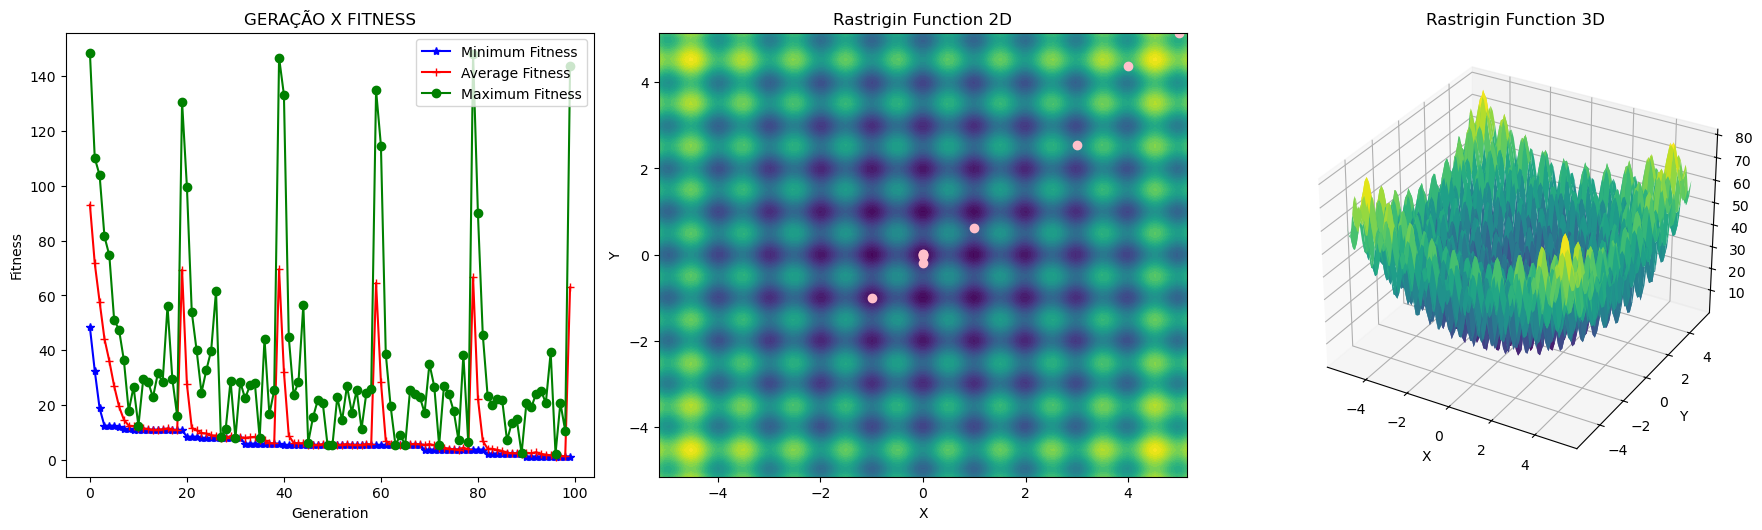

Soluções do problema

Best solution index =  90

Best solution variables =
 [-2.5943151968149176, 4.073837658894861, -2.5920030228610247, 0.6814101257839829, -1.4121387222522457, 4.2821696262801145, -4.838350431035853, -2.997393776537351, -0.5307950708699138, -0.35749552782493765]

Best solution fitness =  1.1823257384567523

Ótimo global da função Rastrigin =  86.5608914154115

Solução ótima global =  [-2.98485540e+00  3.97978394e+00 -2.98485580e+00  9.94958596e-01
 -9.94959042e-01  3.97978383e+00 -4.97469151e+00 -2.98485543e+00
 -9.94959281e-01 -5.08464225e-07]

Porcentagem de proximidade da solução em relação ao ótimo global =  98.63411094880864 %

Distância da solução em relação ao ótimo global = <built-in function abs>


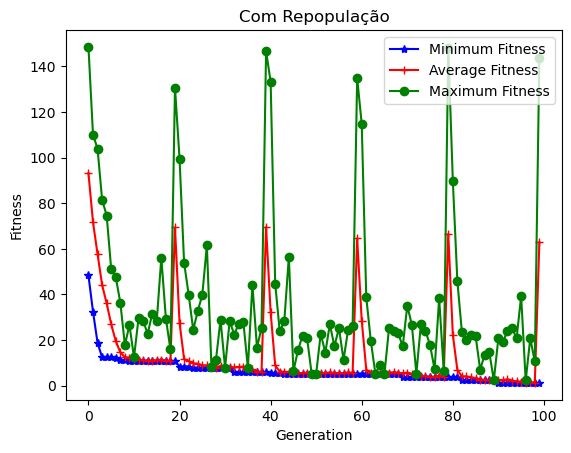

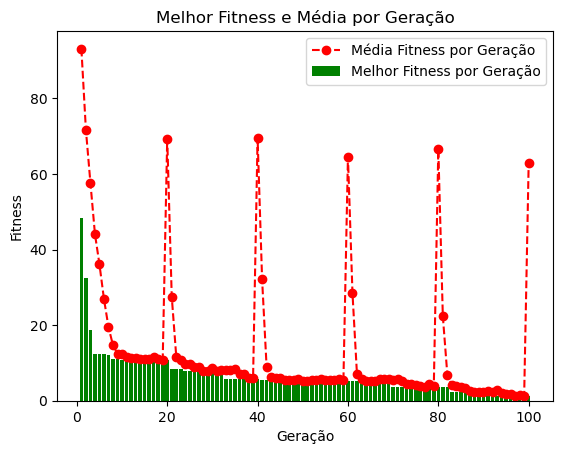

,Generation,Min Fitness,Average Fitness,Max Fitness,Std Fitness
0,0,48.316623,93.128485,148.545342,22.623284
1,1,32.465133,71.675960,110.124748,17.762138
2,2,18.777131,57.657722,103.834087,15.196389
3,3,12.385417,44.142588,81.502363,12.274823
4,4,12.385417,36.074179,74.604012,12.296002
...,...,...,...,...,...
95,95,1.182326,1.658563,39.190194,3.784431
96,96,1.182326,1.193010,2.250759,0.106308
97,97,1.182326,1.513186,20.716723,2.354343
98,98,1.182326,1.276734,10.623193,0.939354


Total execution time: 8.23 seconds


In [5]:
from src.models.AlgEvolution import AlgEvolution

def load_params(file_path):
    with open(file_path, "r") as file:
        params = json.load(file)
    return params

if __name__ == "__main__":
    tempo1 = time.time()

    # Setup
    params = load_params("/home/pedrov/Documentos/GitHub/Engenharia-Eletrica-UFF/Iniciação Cientifica - Eng Eletrica UFF/evolution_rce_master/src/db/parameters.json")
    setup = Setup(params)
    alg = AlgoritimoEvolutivoRCE(setup)
    data_visual = DataExploration()
    # old_alg = AlgEvolution(setup)

    pop_with_repopulation, logbook_with_repopulation, best_variables = alg.run(
        RCE=True,
        fitness_function=rastrigin_decisionVariables,
        decision_variables=(X, y,data_hora,curva,vento),
    )

    print("\n\nEvolução concluída  - 100%")

    # Salvar resultados
    print("\n\nRESULTADOS OBTIDOS")
    data_visual.displayDataFrameInfo(alg.allIndividualValuesArray, "\n\nTodos Individuos Gerados")
    # data_visual.show_conjuntoElite(alg.pop_RCE)
    df = pd.DataFrame(alg.allIndividualValuesArray)
    display(df[df["Generations"]== 20])

    # Visualização dos resultados
    print("\n\nVISUALIZANDO OS RESULTADOS")
    data_visual.show_rastrigin_benchmark(logbook_with_repopulation,best_variables)
    data_visual.visualize(
        logbook_with_repopulation, pop_with_repopulation, repopulation=True
    )
    data_visual.statistics_per_generation_df(logbook_with_repopulation)

    tempo2 = time.time()
    print(f"Total execution time: {round(tempo2-tempo1,2)} seconds")